# Corridas compartilhadas em Chicago

Eu estou analisando os dados da Zuber, uma empresa de compartilhamento de corridas que está sendo lançada em Chicago. Meu objetivo é encontrar padrões nas informações disponíveis. Mais especificamente, eu quero encontrar os destinos mais comuns das corridas e quais empresas são as melhores provedoras de corridas. Adidiconalmente, eu quero testar a hipótese de que o clima do dia afeta a duração médias das corridas.

## Importando bibliotecas e os dados

In [1]:
### bibliotecas
import pandas as pd
import numpy as np
import statistics as sts
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime

In [2]:
### importando dados

## dados de número de corridas por empresa
try:
    company_trips = pd.read_csv('project_sql_result_01.csv')
except:
    company_trips = pd.read_csv('/datasets/project_sql_result_01.csv')
    
## dados de contagem média de corridas por localidade
try:
    location_trips = pd.read_csv('project_sql_result_04.csv')
except:
    location_trips = pd.read_csv('/datasets/project_sql_result_04.csv')
    
## dados de descrição das corridas
try:
    weather = pd.read_csv('project_sql_result_07.csv')
except:
    weather = pd.read_csv('/datasets/project_sql_result_07.csv')

## Preparando os dados

### Estudando os dados

In [3]:
# cabeçalho
company_trips.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [4]:
# informações
company_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [5]:
# duplicatas
company_trips.duplicated().sum()

0

**Comentário**: Nenhum erro de tipagem, dado faltante ou duplicata em `company_trips`

In [6]:
# cabeçalho
location_trips.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [7]:
location_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [8]:
# duplicatas
location_trips.duplicated().sum()

0

**Comentário**: Nenhum dado faltante ou duplicata em `location_trips`. Contudo, `average_trips` está como tipo 'flutuante', o que não faz muito sentido pois não existem frações de corridas. O melhor seria converter para inteiros.

In [9]:
#cabeçalho
weather.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [11]:
# contando duplicadas
weather.duplicated().sum()

197

In [12]:
# porcentagem de duplicadas
dupl_percent = round(weather.duplicated().sum() / weather.shape[0], 2) *100
print(f"A porcentagem de duplicadas nos dados: {dupl_percent}%")

A porcentagem de duplicadas nos dados: 18.0%


In [13]:
# visualizando duplicadas
weather[weather.duplicated()]

,start_ts,weather_conditions,duration_seconds
62,2017-11-11 06:00:00,Good,1260.0
74,2017-11-11 08:00:00,Good,1380.0
76,2017-11-04 09:00:00,Good,1380.0
117,2017-11-11 07:00:00,Good,1380.0
119,2017-11-04 14:00:00,Good,3300.0
...,...,...,...
1054,2017-11-11 07:00:00,Good,1380.0
1058,2017-11-25 12:00:00,Good,1440.0
1062,2017-11-11 06:00:00,Good,1500.0
1065,2017-11-11 13:00:00,Good,2100.0


**Comentário**:  Nenhum dado faltante em `weather`. Existem entradas duplicadas. As duplicadas podem ser reais, pois é pouco provável que existam corridas de mesma duração chegando ao mesmo tempo. Contudo, as duplicadas também podem ocorrer pela falta de precisão no horário de chegada, que foi arredondado. Assim, será melhor deixar as duplicadas, pois elas são uma porcentagem considerável dos dados. Além disso, a variável `start_ts` está como tipo 'object', mas o mais indicado seria 'datetime', para possibilitar a extração de outras informações posteriormente.

### Corrigindo os dados

In [14]:
## mudando tipo de 'average_trips'
location_trips['average_trips'] = location_trips['average_trips'].astype('int')

In [15]:
## mudando nome de colunas
location_trips.rename(columns={"dropoff_location_name": "location"}, inplace=True)

In [16]:
## mudando tipo de 'start_ts'
weather['start_ts'] = pd.to_datetime(weather['start_ts'], format= '%Y-%m-%d %H:%M:%S')

**Comentário**: Mudei os tipos de dados de `average_trips` de 'float' para 'int'. Mudei os tipos de dados de `start_ts` de 'object' para 'datetime'. Também alterei o nome da coluna `dropoff_location_name` para `location`.

## Explorando os dados

### Identificando os principais bairros em termos de destino das corridas

In [17]:
# organizando localidades por número médio de corridas que chegam.
location_trips.sort_values(by ='average_trips', ascending=False, inplace=True)

In [18]:
# selecionando apenas as 10 localidades com mais viagens
top_ten_locations = location_trips[0:10]

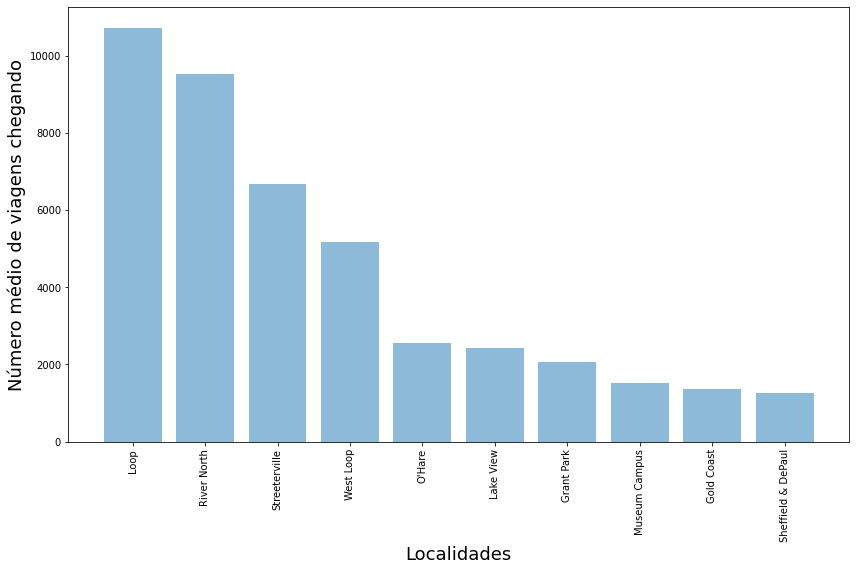

In [19]:
# plotando
plt.figure(figsize=(14,8))
plt.bar(x=top_ten_locations['location'], height= top_ten_locations['average_trips'], alpha=0.5)
plt.xlabel(xlabel="Localidades", fontsize=18)
plt.xticks(rotation='vertical')
plt.ylabel(ylabel="Número médio de viagens chegando", fontsize=18)
plt.show()

**Comentário**: O bairro "Loop" é o destino final da maioria das corridas, recebendo em média mais de 10.000 corridas. Os bairros "River North", "Streeterville" e "West Loop" são os próximo em número médio de corridas recebidas.

### Identificando as principais empresas em relação ao número de corridas

In [20]:
# organizando empresas por número de corridas
company_trips.sort_values(by ='trips_amount', ascending=False, inplace=True)

In [21]:
# selecionando apenas as 10 empresas com mais viagens
company_trips = company_trips[0:10]

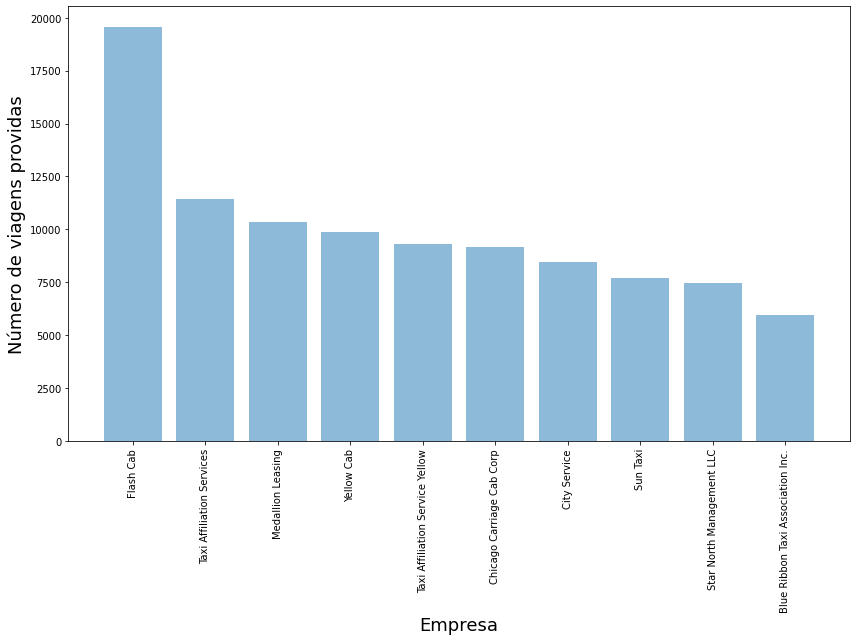

In [22]:
plt.figure(figsize=(14,8))
plt.bar(x= company_trips['company_name'], height= company_trips['trips_amount'], alpha=0.5)
plt.xlabel(xlabel="Empresa", fontsize=18)
plt.xticks(rotation='vertical')
plt.ylabel(ylabel="Número de viagens providas", fontsize=18)
plt.show()

**Comentário**: A empres "Flash Cab" proveu a das corridas, cerca de 20.000 corridas. As empresas "Taxi Affiliation Service", "Medallion Leasing" e "Yellow Cab" são as próximo em número de corridas providas.

## Testando hipóteses

Testando se a duração média das corridas difere entre dias chuvosos ('Bad') e não-chuvosos ('Good'):

Hipótese nula: Não existe diferença na duração média das corridas  entre dias chuvosos e não-chuvosos
Hipótese alternativa: Existe diferença na duração média das corridas  entre dias chuvosos e não-chuvosos

In [23]:
# separando valores de duração de corrida para cada tipo de clima
good_duration = weather.query("weather_conditions == 'Good'")['duration_seconds']
bad_duration = weather.query("weather_conditions == 'Bad'")['duration_seconds']

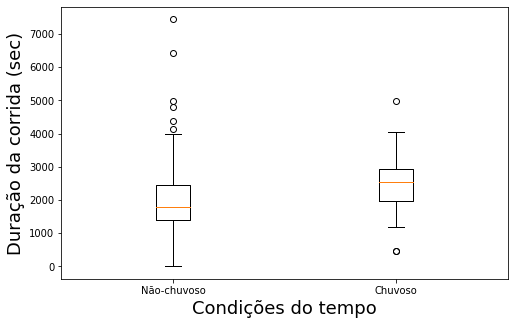

In [38]:
# boxplot
plt.figure(figsize=(8,5))
plt.boxplot([good_duration, bad_duration])
plt.xlabel(xlabel='Condições do tempo', fontsize=18)
plt.xticks([1, 2], ['Não-chuvoso', 'Chuvoso'])
plt.ylabel(ylabel='Duração da corrida (sec)', fontsize=18)
plt.show()

In [25]:
print("A duração média das corridas em dias não-chuvosos:", round(np.mean(good_duration),0) )
print("A duração média das corridas em dias chuvosos:", round(np.mean(bad_duration),0) )

A duração média das corridas em dias não-chuvosos: 2000.0
A duração média das corridas em dias chuvosos: 2427.0


In [26]:
# definindo alfa
alpha = 0.05

In [27]:
# Teste as hipóteses
ttest_1 = st.ttest_ind(good_duration,bad_duration , equal_var = False)
print('p-value:', round(ttest_1.pvalue, 3) )

p-value: 0.0


In [28]:
if ttest_1.pvalue < alpha:
    print("Hipótese nula rejeitada")
else:
    print("Hipótese nula mantida")

Hipótese nula rejeitada


**Comentário geral**: Eu apliquei um teste-t não pareado com variância diferetes para testar se a duração média das corridas difere entre dias chuvosos e não-chuvosos. O teste indicou diferença entre as os dias chuvusos e não-chuvosos, onde a duração das corridas dos dias chucovosos eram maiores que os dias não-chuvosos. 

# Conclusão Geral

Com base nos dados da Zuber, eu notei que os diferentes bairros recebem quantidades diferentes de corridas e que as empresas diferem quanto a quantidade de corridas providas. Além disso, eu constatei que as corridas em dias chuvosos tendem a ser mais longas que as corridas em dias não-chuvosos, em média. 